In [1]:
import os
import sys
root_path_scripts = os.path.abspath(os.path.join(os.getcwd(), '../scripts'))
sys.path.append(root_path_scripts)
root_path_scripts = os.path.abspath(os.path.join(os.getcwd(), '../scripts/visualize_medium_rag_pipe_line'))
sys.path.append(root_path_scripts)


In [3]:
import os
import umap
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from dotenv import load_dotenv, find_dotenv
from load_split_data.load_split import load_document, split_document
from visualize_medium_rag_pipe_line.retrieval import load_embeddings_from_db, query_relevant_documents, vector_store, embeddings_model
from visualize_medium_rag_pipe_line.generator import augment_query_generated, llm
from pymongo import MongoClient
from pymongo.server_api import ServerApi
# Load environment variables from the .env file
load_dotenv(find_dotenv())


True

In [4]:
import os
import sys
from dotenv import load_dotenv, find_dotenv

# Unset the environment variables if they are set
if "OPENAI_API_KEY" in os.environ:
    del os.environ["OPENAI_API_KEY"]
if "MONGODB_URI" in os.environ:
    del os.environ["MONGODB_URI"]

# Load environment variables from the .env file and explicitly reload them
load_dotenv(override=True)

root_path_scripts = os.path.abspath(os.path.join(os.getcwd(), '../scripts'))
sys.path.append(root_path_scripts)

root_path_scripts = os.path.abspath(os.path.join(os.getcwd(), '../scripts/simple_pipeline'))
sys.path.append(root_path_scripts)

# from load_split import load_document, split_document
from retrieval import add_documents_to_vector_store
from generator import generate_response
from evaluator import load_evaluation_data, evaluate_responses, print_evaluation_results

# Load and split the document
# file_path = '../data/short_contracts/Robinson_Advisory.docx'  # Change to your document path
# data = load_document(file_path)
# chunks = split_document(data)

# Add chunks to the vector store
# add_documents_to_vector_store(chunks)

# Generate a response
question = "What is the termination notice?"
response = generate_response(question)
print(response)



{'query': 'What is the termination notice?', 'result': "The termination notice for this agreement is fourteen (14) days' prior written notice. However, the Company may terminate this Agreement immediately and without prior notice if the Advisor refuses or is unable to perform the Services, or is in breach of any provision of this Agreement.", 'source_documents': [Document(metadata={'_id': ObjectId('6688c55d851e65b436cf2997'), 'embedding': [-0.012158920886661298, -0.010684100821587359, -0.0169370694530842, -0.022863041418145012, -0.026052923654984544, 0.018899045726410147, -0.023717235575270893, -0.013827268849797788, -0.0017367503460404058, -0.027440989160314105, 0.020834330294971042, 0.02482501955411609, -0.014841624411384773, 0.008114844492695882, 0.010724141172702635, -0.024064251951603284, 0.014000777037963982, 0.003950647976707206, -0.0005234442025379036, 0.0020904401142253417, -0.010557305910727703, 0.005338713482036765, -0.04986358764751365, 0.016243036700419423, -0.005388764153

In [5]:
# Retrieve environment variables
db_uri = os.getenv("MONGODB_URI")

# Database configuration
client = MongoClient(db_uri, server_api=ServerApi('1'))

# Updated database and collection names
LizzyAI_ContractsDB = client["LizzyAI_Contracts"]
lizzyai_collection = LizzyAI_ContractsDB["contracts"]

# Load embeddings from MongoDB
embeddings, documents = load_embeddings_from_db(lizzyai_collection)

# UMAP transformation
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)

def project_embeddings(embeddings, umap_transform):
    umap_embeddings = np.empty((len(embeddings), 2))
    for i, embedding in enumerate(tqdm(embeddings)): 
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings

projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)


/home/air/week11/.week11/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
100%|██████████| 20/20 [00:19<00:00,  1.00it/s]


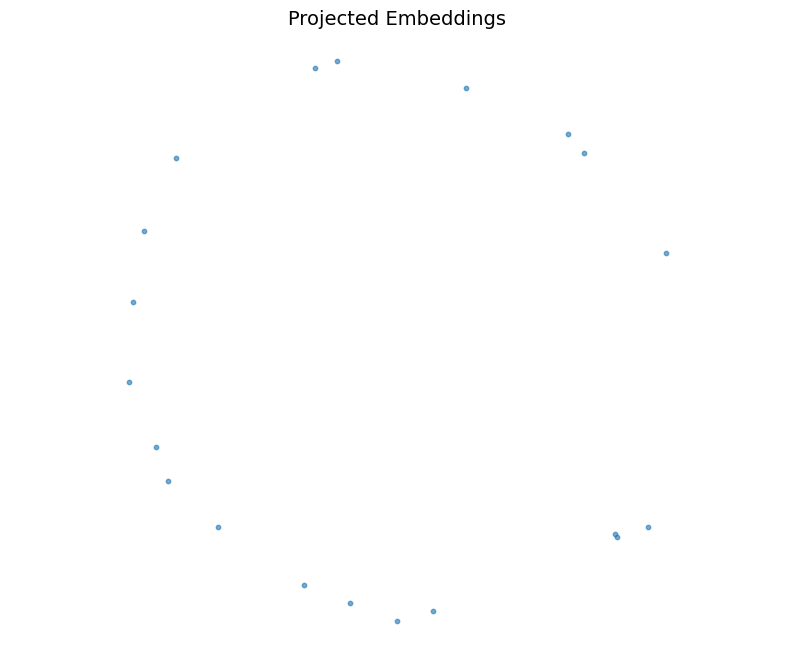

In [6]:

# Visualization of the dataset embeddings
plt.figure(figsize=(10, 8))
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, alpha=0.6)
plt.gca().set_aspect('equal', 'datalim')
plt.title('Projected Embeddings', fontsize=14)
plt.axis('off')
plt.show()


In [7]:

# Example query
original_query = "Who owns the IP?"

# Augment the query
hypothetical_answer = augment_query_generated(original_query)
joint_query = f"{original_query} {hypothetical_answer}"
# print(word_wrap(joint_query))

# Retrieve documents using the expanded query
retrieved_documents = query_relevant_documents(joint_query, vector_store)

# Function to print documents nicely
def word_wrap(text, width=80):
    return '\n'.join([text[i:i+width] for i in range(0, len(text), width)])

# # Print the retrieved documents
# for document in retrieved_documents:
#     print(word_wrap(document.page_content))
#     print('')

# Assuming embeddings are included in the documents retrieved
retrieved_embeddings = [doc.metadata['embedding'] for doc in retrieved_documents]

# Retrieve embeddings for visualization
original_query_embedding = embeddings_model.embed_query(original_query)
augmented_query_embedding = embeddings_model.embed_query(joint_query)

# Project query and retrieved embeddings
projected_original_query_embedding = project_embeddings([original_query_embedding], umap_transform)
projected_augmented_query_embedding = project_embeddings([augmented_query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)



/home/air/week11/.week11/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `BaseChatModel.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(
/home/air/week11/.week11/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(
100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


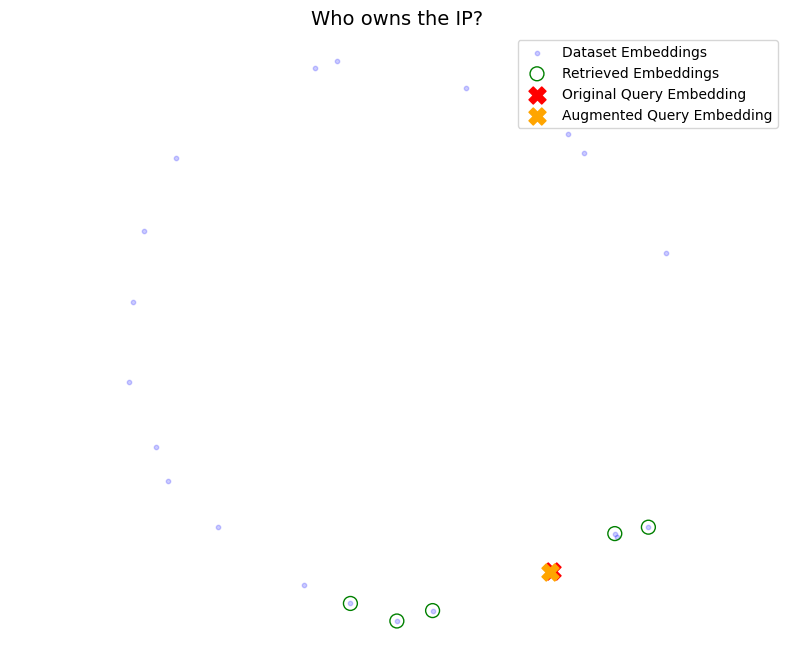

In [10]:
plt.figure(figsize=(10, 8))
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, alpha=0.2, color = 'b', label='Dataset Embeddings')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g', label='Retrieved Embeddings')
plt.scatter(projected_original_query_embedding[:, 0], projected_original_query_embedding[:, 1], s=150, marker='X', color='r', label='Original Query Embedding')
plt.scatter(projected_augmented_query_embedding[:, 0], projected_augmented_query_embedding[:, 1], s=150, marker='X', color='orange', label='Augmented Query Embedding')
plt.gca().set_aspect('equal', 'datalim')
plt.title(original_query, fontsize=14)
plt.legend()
plt.axis('off')
plt.show()


In [11]:

# Load the evaluation dataset
evaluation_data = load_evaluation_data('evaluation_dataset.json')

# Initialize a list to store all the responses
responses = []

# Loop through each question in the evaluation dataset
for item in evaluation_data:
    question = item['question']
    ground_truth = item['answer']

    # Generate a response
    response = generate_response(question)
    
    # Store the response and ground truth
    responses.append({
        'query': question,
        'result': response['result'],
        'source_documents': response['source_documents'],
        'ground_truths': [ground_truth]
    })

# Evaluate the responses
evaluation_results = evaluate_responses(responses)

# Print evaluation results
print_evaluation_results(evaluation_results)



Evaluation Results:
                                           questions  \
0  Who are the parties to the Agreement and what ...   
1                    What is the termination notice?   
2  Who are the parties to the Agreement and what ...   
3                    What is the termination notice?   
4  What are the payments to the Advisor under the...   
5  Can the Agreement or any of its obligations be...   

                                            contexts  \
0  Entire Agreement; No Waiver or Assignment: Thi...   
1  Term: The term of this Agreement shall commenc...   
2  Entire Agreement; No Waiver or Assignment: Thi...   
3  Term: The term of this Agreement shall commenc...   
4  salary payments, and 40% of such payments shal...   
5  Entire Agreement; No Waiver or Assignment: Thi...   

                                              answer  \
0  The parties to the Agreement are Cloud Investm...   
1  The termination notice for this agreement is f...   
2  The parties to the Agr

In [8]:
# import pandas as pd
# df_results = pd.DataFrame(evaluation_results)
# # Set display options to show more characters in each column
# pd.set_option('display.max_colwidth', None)
# display(df_results.style.set_properties(**{'text-align': 'left'}))

In [11]:
# Example query
original_query = "Who owns the IP?"

response = generate_response(original_query)
response["result"]

'The IP (Intellectual Property) is fully and exclusively owned by the Company, Cloud Investments Ltd.'